In [1]:
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
from scipy import optimize
import math
from matplotlib.patches import Polygon

from RoutePlanner.Mesh import Mesh
from RoutePlanner.Plot import PlotMesh
from RoutePlanner.Optimisation import TravelTime

In [2]:
IceExtent = {}
IceExtent['X']      = np.load('./resources/IceContent_X.npy') 
IceExtent['Y']      = np.load('./resources/IceContent_Y.npy') 
IceExtent['Values'] = np.load('./resources/IceContent_V.npy') 
IceExtent['Mask']   = np.load('./resources/IceContent_mask.npy') 
vls = IceExtent['Values']
vls[IceExtent['Mask']] = 1.0
IceExtent['Values'] = vls


Coastline = {}
Coastline['X']      = np.load('./resources/IceContent_X.npy') 
Coastline['Y']      = np.load('./resources/IceContent_Y.npy')
values = np.load('./resources/IceContent_V.npy'); values[values < 1] = 0
Coastline['Values'] = values

Currents = {}
Currents['X']  =  np.load('./resources/Current_X.npy') 
Currents['Y']  =  np.load('./resources/Current_Y.npy') 
Currents['Vx'] = np.load('./resources/Current_Vx.npy')
Currents['Vy'] = np.load('./resources/Current_Vy.npy')

Waypoints = pd.read_csv('./resources/WayPoints.csv')

In [3]:
MeshInfo = {}
MeshInfo['Xmin'] = 260
MeshInfo['Xmax'] = 360
MeshInfo['Ymin'] = -75
MeshInfo['Ymax'] = -40
MeshInfo['dx']   = 5
MeshInfo['dy']   = 2.5

MeshInfo['CoastMask'] = {}
MeshInfo['CoastMask']['X']          = Coastline['X'] 
MeshInfo['CoastMask']['Y']          = Coastline['Y'] 
MeshInfo['CoastMask']['Mask']       = Coastline['Values'].astype(bool)
MeshInfo['CoastMask']['Split']      = False
MeshInfo['CoastMask']['SplitDepth'] = 1

MeshInfo['IceExtent'] = {}
MeshInfo['IceExtent']['X']          = IceExtent['X'] 
MeshInfo['IceExtent']['Y']          = IceExtent['Y'] 
MeshInfo['IceExtent']['Values']     = IceExtent['Values']
MeshInfo['IceExtent']['Mask']       = IceExtent['Mask']
MeshInfo['IceExtent']['Split']      = False 
MeshInfo['IceExtent']['SplitDepth'] = 1
MeshInfo['IceExtent']['SplitDiff']  = 0.1
MeshInfo['IceExtent']['MaxProportion'] = 0.8

MeshInfo['Currents'] = {}
MeshInfo['Currents']['X']  = Currents['X'] 
MeshInfo['Currents']['Y']  = Currents['Y']
MeshInfo['Currents']['Vx'] = Currents['Vx'] 
MeshInfo['Currents']['Vy'] = Currents['Vy'] 




### Generating Mesh from Land & Ice Content

In [4]:
mesh = Mesh(MeshInfo)
mesh.IceInformation()
mesh.VectorInformation()


=============== Initialising Mesh ================
Xmin=260,Xmax=360,dX=5  Ymin=-75,Ymax=-40,dY=2.5

============ GRIDDING LAND INFORMATION ===========
~~~~~~~~ Initialising Original Mask Array ~~~~~~~~

============ GRIDDING ICE INFORMATION ===========
~~~~~~~~ Initialising Original Mask Array ~~~~~~~~

============ GRIDDING Current Data ===============


### Plotting Generated Mesh

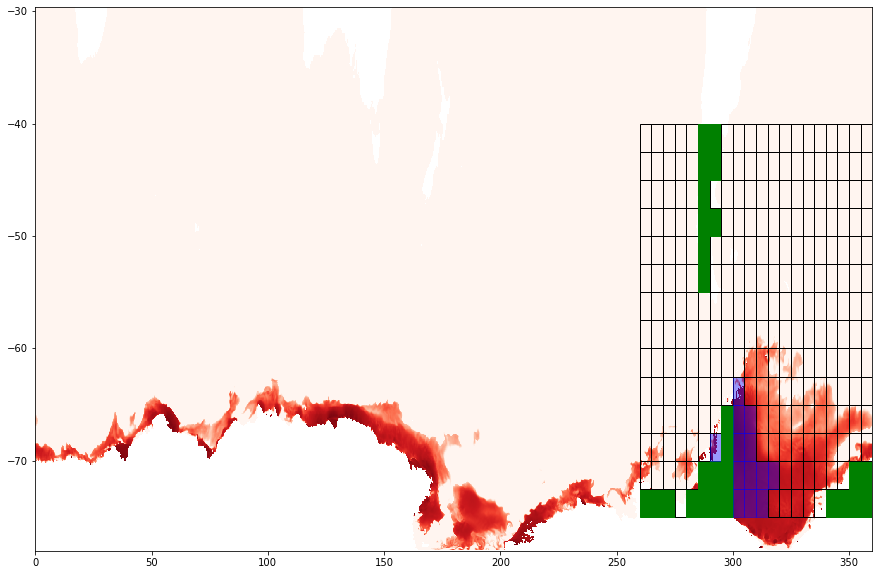

In [5]:
PlotMesh(mesh)

# Optimisation

In [6]:
OptInfo = {}
OptInfo['WayPoints']            = Waypoints[['Name','Long','Lat']]
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3

In [7]:
TT = TravelTime(mesh,OptInfo)

C:\Users\jonsmi\Miniconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
TT.optimize()

AttributeError: 'TravelTime' object has no attribute 'cells'